In [530]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.engine import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sys
import os


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

In [531]:
market_data_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_1.csv"), sep=";")
market_data_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_2.csv"), sep=";")
market_data_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "prices_round_4_day_3.csv"), sep=";")

trades_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_1.csv"), sep=";")
trades_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_2.csv"), sep=";")
trades_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "trades_round_4_day_3.csv"), sep=";")

observations_round_4_day_1 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_1.csv"), sep=",")
observations_round_4_day_2 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_2.csv"), sep=",")
observations_round_4_day_3 = pd.read_csv(os.path.join("..", "data", "round4", "observations_round_4_day_3.csv"), sep=",")

market_data_round_4_all3days = concatenate_historical_data([market_data_round_4_day_1, market_data_round_4_day_2, market_data_round_4_day_3])
trades_round_4_all3days = concatenate_historical_data([trades_round_4_day_1, trades_round_4_day_2, trades_round_4_day_3])
observations_round_4_all3days = concatenate_historical_data([observations_round_4_day_1, observations_round_4_day_2, observations_round_4_day_3])

maybe different values of sunlight mean different regimes? 

In [532]:
MAGNIFICENT_MACARONS = "MAGNIFICENT_MACARONS"

md = market_data_round_4_day_3.copy().reset_index()
th = trades_round_4_day_3.copy().reset_index()
obs = observations_round_4_day_3.copy().reset_index()

md = md[md["product"] == MAGNIFICENT_MACARONS]
th = th[th["symbol"] == MAGNIFICENT_MACARONS]


l, h = 0, 3e6
md = md[(md["timestamp"] >= l) & (md["timestamp"] < h)].reset_index(drop=True)
th = th[(th["timestamp"] >= l) & (th["timestamp"] < h)].reset_index(drop=True)
obs = obs[(obs["timestamp"] >= l) & (obs["timestamp"] < h)].reset_index(drop=True)

obs["actual_ask"] = obs["askPrice"] + obs["transportFees"] - obs["importTariff"]
obs["actual_bid"] = obs["bidPrice"] - obs["transportFees"] - obs["exportTariff"]


obs.columns, md.columns

(Index(['index', 'timestamp', 'bidPrice', 'askPrice', 'transportFees',
        'exportTariff', 'importTariff', 'sugarPrice', 'sunlightIndex',
        'actual_ask', 'actual_bid'],
       dtype='object'),
 Index(['index', 'day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
        'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
        'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
        'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss'],
       dtype='object'))

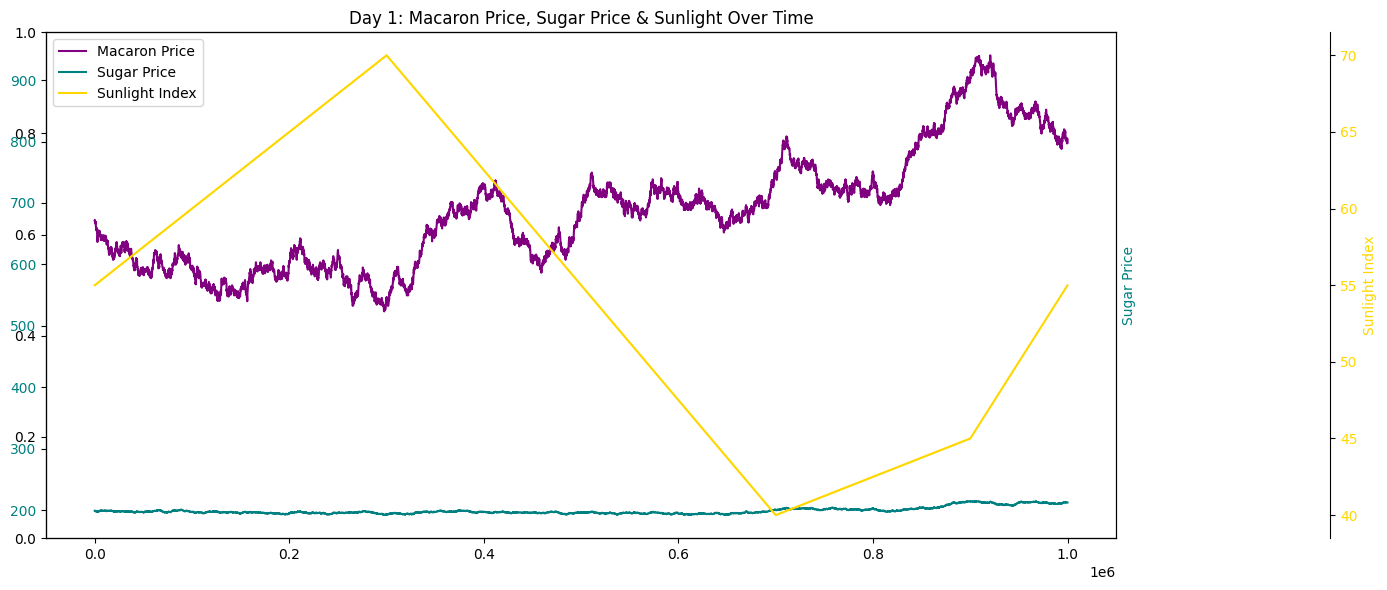

In [533]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Make sure your timestamps are actual datetime objects (or numeric index)
# If they’re integers you can leave as is, otherwise:
# 2) Pick your three series
ts = md["timestamp"]
macarons = md["mid_price"]
sugar = obs["sugarPrice"]
sunlight = obs["sunlightIndex"]

# 3) Set up the figure and axes
fig, ax2 = plt.subplots(figsize=(14, 6))

# second y‑axis
ax2 = ax2.twinx()
# third y‑axis: offset it to the right
ax3 = ax2.twinx()
ax3.spines["right"].set_position(("axes", 1.2))  # 20% further to the right

# 4) Plot each series
(p1,) = ax2.plot(ts, macarons, color="purple", label="Macaron Price")
(p2,) = ax2.plot(ts, sugar, color="teal", label="Sugar Price")
(p3,) = ax3.plot(ts, sunlight, color="gold", label="Sunlight Index")

# 5) Labeling
ax2.set_xlabel("Time")
ax2.set_ylabel("Macaron Price", color="purple")
ax2.set_ylabel("Sugar Price", color="teal")
ax3.set_ylabel("Sunlight Index", color="gold")

# tick colors
ax2.tick_params(axis="y", labelcolor="purple")
ax2.tick_params(axis="y", labelcolor="teal")
ax3.tick_params(axis="y", labelcolor="gold")

# 6) Combined legend
lines = [p1, p2, p3]
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc="upper left")

plt.title("Day 1: Macaron Price, Sugar Price & Sunlight Over Time")
plt.tight_layout()
plt.show()

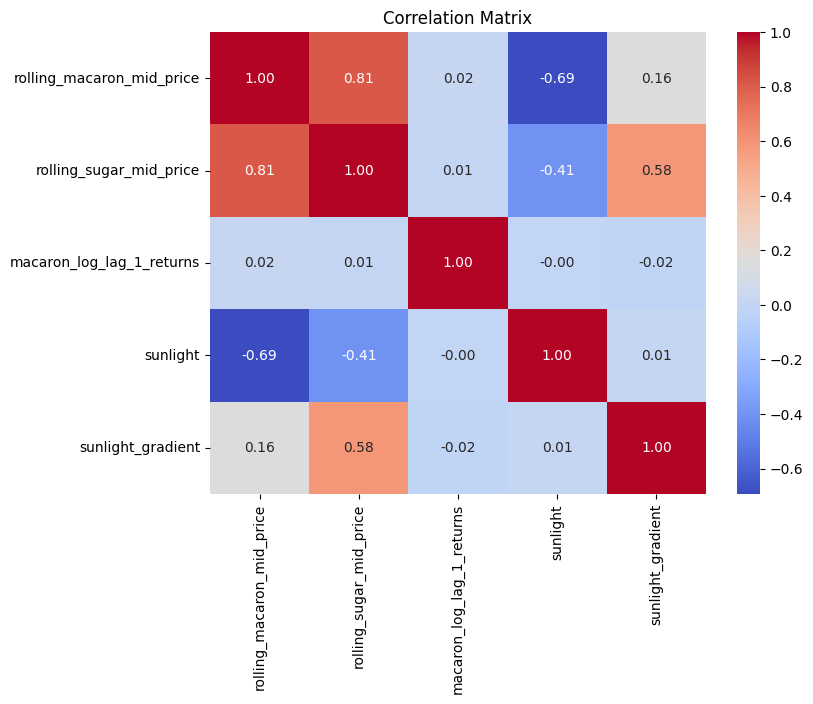

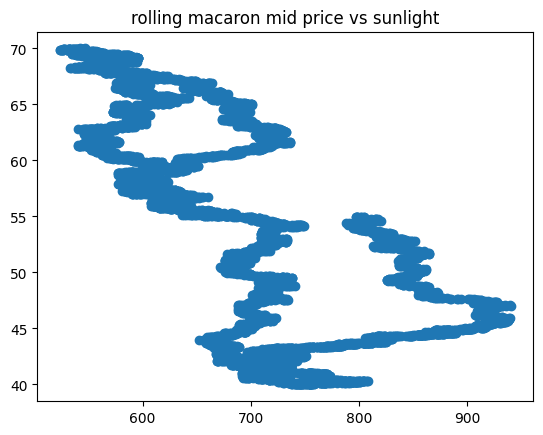

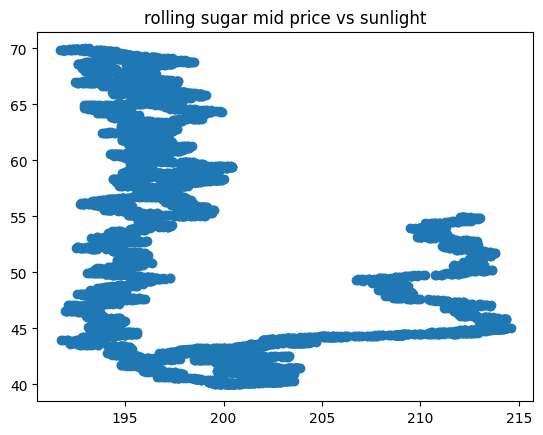

In [534]:
import seaborn as sns
import matplotlib.pyplot as plt

datadf = pd.DataFrame()
datadf["rolling_macaron_mid_price"] = md["mid_price"].rolling(1).mean()
datadf["rolling_sugar_mid_price"] = obs["sugarPrice"].rolling(1).mean()


datadf["macaron_log_lag_1_returns"] = np.log(md["mid_price"]) - np.log(md["mid_price"]).shift(1)

datadf["sunlight"] = obs["sunlightIndex"]


datadf["sunlight_gradient"] = (obs["sunlightIndex"] - obs["sunlightIndex"].shift(1)).rolling(30).mean()


# Compute correlation matrix
corr_matrix = datadf.corr()

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


plt.figure()
plt.title("rolling macaron mid price vs sunlight")
plt.scatter(datadf["rolling_macaron_mid_price"], datadf["sunlight"])

plt.figure()
plt.title("rolling sugar mid price vs sunlight")
plt.scatter(datadf["rolling_sugar_mid_price"], datadf["sunlight"])

what about looking at sugar and macarons? Surely they must be related.  
- Potentially we could trade the spread
- Potentially we could use one to predict the other and just be positional.   
- Potentially we could market make on both.  



In [ ]:
import statsmodels.api as sm

# Prepare data
window = 1
data = pd.DataFrame()
data["timestamp"] = md["timestamp"]
data["sugar"] = obs["sugarPrice"].rolling(window).mean()
data["macaron"] = md["mid_price"].rolling(window).mean()
data["sunlight"] = datadf["sunlight"]

data["sunlight_gradient"] = datadf["sunlight_gradient"]
# data['sunlight_x_sugar'] = datadf['sunlight']*data['sugar']
# data['sunlight_gradient_x_sugar'] = datadf['sunlight_gradient']*data['sugar']

lag = 1

data["sugar_returns_nominal"] = data["sugar"] - data["sugar"].shift(lag)
data["macaron_returns_nominal"] = data["macaron"] - data["macaron"].shift(lag)
data["sugar_returns_pct"] = data["sugar"] / data["sugar"].shift(lag) - 1
data["macaron_returns_pct"] = data["macaron"] / data["macaron"].shift(lag) - 1
data["sugar_logreturns"] = np.log(data["sugar"]) - np.log(data["sugar"]).shift(lag)
data["macaron_logreturns"] = np.log(data["macaron"]) - np.log(data["macaron"]).shift(lag)


data["macaron_sqrtreturns"] = np.sqrt(data["macaron_returns_nominal"])
data["sunlight_squared"] = np.power(data["sunlight"], 2)


data["sugar_returns_pct_sq"] = np.power(data["sugar_returns_pct"] + 1, 2)
# data.dropna(inplace=True)


# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))
# sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Matrix")
# plt.show()

In [536]:
# plt.scatter(data['sugar_logreturns'], data['macaron_logreturns'])

When sunlight is high, macaron price is low.  
when sunlight is low, macaron price is high.  

when sunlight is somewhere in the middle,  i dont' think it has much effect on the macaron price.

In [537]:
# sunlight = obs['sunlightIndex']

# mean = np.mean(sunlight)
# std= np.std(sunlight)

# # data = data[(data['sunlight'] >= mean + 1*std) | (data['sunlight'] <= mean-1*std)]

# plt.scatter(data['sunlight'], data['macaron'])
# plt.show()

In [538]:
data["import_tariff"] = obs["importTariff"]
data["export_tariff"] = obs["exportTariff"]
data["transport_fees"] = obs["transportFees"]

ok idk im gonna try spamming features

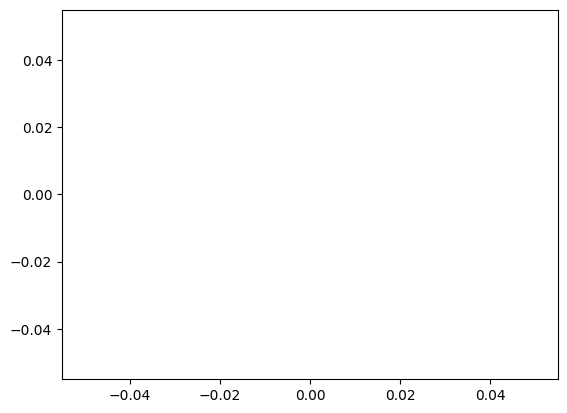

In [539]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeRegressor, plot_tree
# from sklearn.metrics import mean_squared_error, r2_score
# import matplotlib.pyplot as plt

# df = data.copy()
# df.dropna(inplace=True)
# # 1. Prepare X and y
# features = ["sunlight_gradient", "sugar", "import_tariff", "export_tariff", "transport_fees"]
# X = df[features]
# y = df["macaron"]

# # 2. Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 3. Fit the tree
# tree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10)  # you can tune this
# tree.fit(X_train, y_train)

# # 4. Predictions & evaluation
# y_pred = tree.predict(X_test)
# print("MSE:", mean_squared_error(y_test, y_pred))
# print("R²:", r2_score(y_test, y_pred))

# # 5. (Optional) Visualize the tree
# plt.figure(figsize=(16, 8))
# plot_tree(tree, feature_names=features, filled=True, rounded=True, fontsize=10)
# plt.show()


# import matplotlib.pyplot as plt

# # If y_test has a non‑sequential index, reset it so plotting lines up
# y_test_reset = y_test.reset_index(drop=True)

# plt.figure(figsize=(12, 6))
# plt.plot(y_test_reset,   marker='o', linestyle='-', label='Actual macaron price')
# plt.plot(y_pred,         marker='x', linestyle='--', label='Predicted macaron price')
# plt.xlabel('Test sample #')
# plt.ylabel('Macaron price')
# plt.title('Actual vs Predicted on Test Set')
# plt.legend()
# plt.tight_layout()
# plt.show()

plt.scatter(data["sugar_returns_pct"], data["macaron_returns_pct"])

In [540]:
import plotly.express as px

x, y, z = "sugar_returns_pct", "sunlight_gradient", "macaron_returns_pct"
df3 = data.dropna(subset=[x, y, z])

# 2) Create the 3D scatter with size parameters
fig = px.scatter_3d(df3, x=x, y=y, z=z, color=z, labels={x: x, y: y, z: z}, title=f"Interactive 3D: {x} vs {y} vs {z}", width=1400, height=800)

# (Optional) further tweak margins or camera in update_layout
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=50),
)

fig.show()

In [541]:
# # Lets test for autocorrelation

# lag = 1
# data[f"sugar_returns_pct_lag_{lag}"] = data['sugar_returns_pct'].shift(lag)


# plt.figure()
# plt.scatter(data[f"sugar_returns_pct_lag_{lag}"], data['sugar_returns_pct'])
# plt.xlabel(f"sugar_returns_pct_lag_{lag}")
# plt.ylabel('sugar_returns_pct')


# # these all just seem like np.rand()'s
# # plt.figure()
# # plt.plot((data[data['timestamp']<=3e3])['timestamp'], (data[data['timestamp']<=3e3])['sugar_returns_pct'])


# # plt.figure()
# # plt.plot((data[data['timestamp']<=3e3])['timestamp'], (data[data['timestamp']<=3e3])['sugar_returns_pct'].diff())
import numpy as np

# make sure both series are aligned & NaNs dropped
tmp = data[["macaron_returns_pct", "sugar_returns_pct"]].dropna()

# test lags from –10 to +10
lags = np.arange(-10, 11)
ccfs = [tmp["macaron_returns_pct"].corr(tmp["sugar_returns_pct"].shift(l)) for l in lags]

best_lag = lags[np.nanargmax(np.abs(ccfs))]
print("Best lag:", best_lag, "corr =", ccfs[lags.tolist().index(best_lag)])

from statsmodels.tsa.api import VAR

ts = data[["macaron_returns_pct", "sugar_returns_pct"]].dropna()
model = VAR(ts)
res = model.fit(maxlags=5, ic="aic")
print(res.summary())

ValueError: All-NaN slice encountered

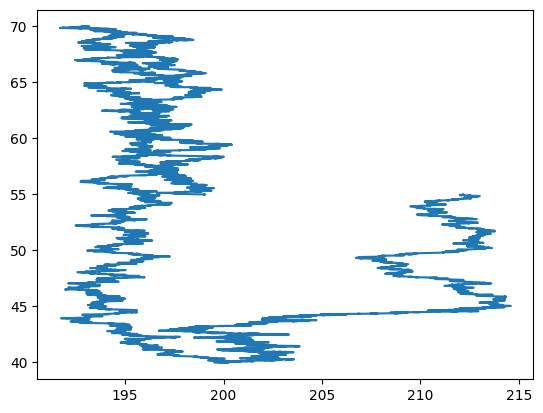

In [ ]:
plt.plot(data["sugar"], data["sunlight"])

C:\Users\raoj6\AppData\Local\Temp\ipykernel_20272\528126080.py:17: MatplotlibDeprecationWarning:

The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.



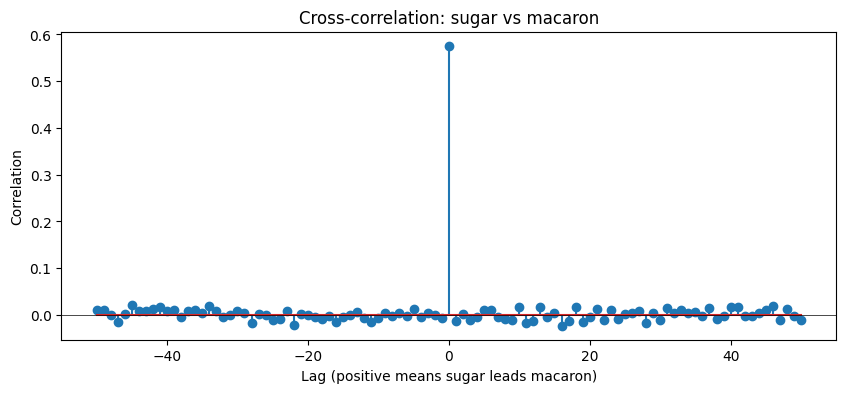

Max |corr| at lag = 0: corr = 0.576


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pick your return series (or use levels if you prefer)
s = data["sugar_returns_pct"]
m = data["macaron_returns_pct"]

# align and drop NaNs
tmp = pd.concat([s, m], axis=1).dropna()

maxlag = 50
lags = np.arange(-maxlag, maxlag + 1)
cors = [tmp["sugar_returns_pct"].corr(tmp["macaron_returns_pct"].shift(l)) for l in lags]

# plot
plt.figure(figsize=(10, 4))
plt.stem(lags, cors, use_line_collection=True)
plt.axhline(0, color="k", lw=0.5)
plt.xlabel("Lag (positive means sugar leads macaron)")
plt.ylabel("Correlation")
plt.title("Cross‑correlation: sugar vs macaron")
plt.show()

# find the strongest
best_idx = np.nanargmax(np.abs(cors))
print(f"Max |corr| at lag = {lags[best_idx]}: corr = {cors[best_idx]:.3f}")

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss


def stationarity_tests(series, name):
    s = series.dropna()
    print(f"\n── Testing {name} ──")

    # 1) ADF
    adf_stat, adf_p, *_ = adfuller(s)
    print(f"ADF    statistic = {adf_stat:.4f},  p‑value = {adf_p:.4f}")
    if adf_p < 0.05:
        print("  → reject H0: series is stationary by ADF")
    else:
        print("  → fail to reject H0: series is non‑stationary by ADF")

    # 2) KPSS
    kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")
    print(f"KPSS   statistic = {kpss_stat:.4f},  p‑value = {kpss_p:.4f}")
    if kpss_p > 0.05:
        print("  → fail to reject H0: series is stationary by KPSS")
    else:
        print("  → reject H0: series is non‑stationary by KPSS")


# Example: test your raw returns
stationarity_tests(data["sugar_returns_pct"], "Sugar % Returns")
stationarity_tests(data["macaron_returns_pct"], "Macaron % Returns")

# …and on your 200‑MA versions if you like:
stationarity_tests(data["sugar_returns_pct"].rolling(200).mean(), "Sugar % Returns (200‑MA)")
stationarity_tests(data["macaron_returns_pct"].rolling(200).mean(), "Macaron % Returns (200‑MA)")


── Testing Sugar % Returns ──
ADF    statistic = -101.3156,  p‑value = 0.0000
  → reject H0: series is stationary by ADF
KPSS   statistic = 0.1815,  p‑value = 0.1000
  → fail to reject H0: series is stationary by KPSS

── Testing Macaron % Returns ──
ADF    statistic = -25.0210,  p‑value = 0.0000
  → reject H0: series is stationary by ADF
KPSS   statistic = 0.1029,  p‑value = 0.1000
  → fail to reject H0: series is stationary by KPSS

── Testing Sugar % Returns (200‑MA) ──


C:\Users\raoj6\AppData\Local\Temp\ipykernel_20272\3175364409.py:17: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\raoj6\AppData\Local\Temp\ipykernel_20272\3175364409.py:17: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




ADF    statistic = -5.9396,  p‑value = 0.0000
  → reject H0: series is stationary by ADF
KPSS   statistic = 0.8141,  p‑value = 0.0100
  → reject H0: series is non‑stationary by KPSS

── Testing Macaron % Returns (200‑MA) ──
ADF    statistic = -4.8032,  p‑value = 0.0001
  → reject H0: series is stationary by ADF
KPSS   statistic = 0.2503,  p‑value = 0.1000
  → fail to reject H0: series is stationary by KPSS


C:\Users\raoj6\AppData\Local\Temp\ipykernel_20272\3175364409.py:17: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\raoj6\AppData\Local\Temp\ipykernel_20272\3175364409.py:17: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




sugar returns and macaron returns are stationary.

In [ ]:
from statsmodels.tsa.stattools import coint

score, pvalue, _ = coint(md["mid_price"], obs["sugarPrice"])
print("p‑value:", pvalue)
# not cointegrated

p‑value: 0.6651081088955998


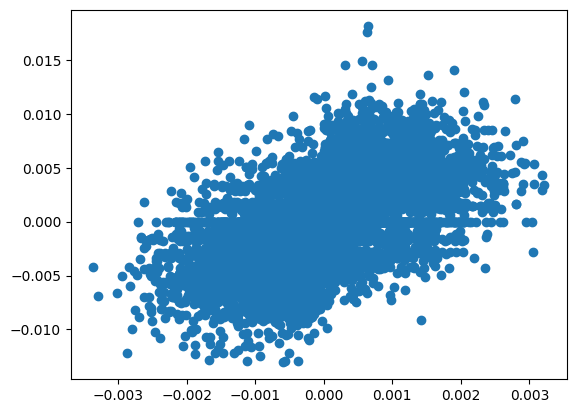

In [ ]:
plt.scatter(data["sugar_returns_pct"], data["macaron_returns_pct"])

# if i shift, there is like 0 correlation
# so there is only correlation at the same timestamp, which is quite useless.